In [341]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import os
import matplotlib.pyplot as plt
import numpy
import pandas
import tensorflow as tf
import seaborn
import gensim

In [16]:
from assistment_dataset import AssistmentDataset
from models import embedded_dkt
from quick_experiment import utils
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [364]:
seaborn.set(style='white', rc={'figure.figsize':(11.7,8.27)})

In [312]:
def get_outputs(model, samples=1):
    sequence_output = []

    for iteration in range(samples):
        batch_instances = []
        start = 0
        for feed_dict in model._fill_feed_dict('train'):
            output = model.sess.run(model.state_op, feed_dict=feed_dict)
            for instance_index, (instance_output, instance, lenght, label) in enumerate(
                    zip(output, feed_dict[model.instances_placeholder],
                        feed_dict[model.lengths_placeholder], feed_dict[model.labels_placeholder])):
                for time_step, (time_step_action, time_step_output) in enumerate(
                        zip(instance[:lenght], instance_output[:lenght])):
                    batch_instances.append([
                        instance_index+(model.batch_size*iteration), time_step+start,
                        time_step_output, numpy.abs(time_step_action), numpy.sign(time_step_action)])
            start += model.max_num_steps
        sequence_output.extend(batch_instances)

    return pandas.DataFrame(data=sequence_output, columns=['student', 'time_step', 'output', 'action', 'label'])

In [301]:
def graphic_students(vectors, student_ids, xcol='pca1', ycol='pca2', action_vectors=None, lines=True,
                     annotate=False):
    for student in student_ids:
        student_sequence = vectors[vectors.student == student]
        if action_vectors is not None:
            used_actions = [int(x) for x in student_sequence.action.unique()]
            plt.scatter(action_vectors[used_actions,0], action_vectors[used_actions,1], marker='*',
                        c='black', s=200)
            for action_id in used_actions:
                plt.annotate(str(action_id), action_vectors[action_id])
        ax = plt.scatter(student_sequence[xcol].values, student_sequence[ycol].values, cmap='gnuplot',
                         c=student_sequence.time_step.values, marker='o')
        if lines:
            plt.plot(student_sequence[xcol].values, student_sequence[ycol].values, lw=1)
        if annotate:
            for (action, x, y, label) in zip(student_sequence.action.values, 
                                      student_sequence[xcol].values, student_sequence[ycol].values,
                                      student_sequence.label.values):
                plt.annotate('{}-{}'.format(int(action), int(label)), (x, y))
    plt.colorbar(label="Time")
    seaborn.despine()

In [457]:
def plot_action_transition(vectors, actions=1, xcol='pca1', ycol='pca2'):
    colnames = [xcol, ycol, 'label', 'time_step']
    plt.figure(1)
    for plot_index, action in enumerate(
            vectors.groupby('action')['action'].count().sort_values(ascending=False).index[:actions]):
        origin_vectors = vectors[vectors.action == action][['student'] + colnames].rename(
            columns={colname: 'origin-' + colname for colname in colnames})
        # Plot
        xaxis_origin = origin_vectors['origin-' + xcol].sort_values().values.tolist()
        yaxis_origin = origin_vectors['origin-' + ycol].sort_values().values.tolist()
        xaxis_diff = numpy.zeros((origin_vectors.shape[0], origin_vectors.shape[0]))
        yaxis_diff = numpy.zeros((origin_vectors.shape[0], origin_vectors.shape[0]))
        labels =  numpy.zeros((origin_vectors.shape[0], origin_vectors.shape[0]))
        colors = {-1: 'r', 0: 'k', 1: 'b'}

        dfs = dict(tuple(origin_vectors.groupby(['student', 'origin-time_step'])))
        dest_vectors = []
        for (student, origin_time_step), value in dfs.items():
            previous_action = vectors[(vectors.student == student) & (vectors.time_step == origin_time_step - 1)]
            origin_coord1 = xaxis_origin.index(value['origin-' + xcol].values[0])
            origin_coord2 = yaxis_origin.index(value['origin-' + ycol].values[0])
            if previous_action.shape[0] == 0:
                continue
            xaxis_diff[origin_coord1, origin_coord2] = previous_action[xcol] - value['origin-' + xcol].values[0]
            yaxis_diff[origin_coord1, origin_coord2] = previous_action[ycol] - value['origin-' + ycol].values[0]
            labels[origin_coord1, origin_coord2] = value['origin-label'].values[0] + 1
        plt.subplot((actions//2 + 1)*100 + plot_index + 1 + 20)
        plt.quiver(xaxis_origin, yaxis_origin, xaxis_diff, yaxis_diff, labels, scale=1, units='xy', cmap='Set2')
        plt.xlim((xaxis_origin[0] - 0.5, xaxis_origin[-1] + 0.5))
        plt.ylim((yaxis_origin[0] - 0.5, yaxis_origin[-1] + 0.5))
    plt.show()
        
#         following_action['origin-time_step'] = origin_time_step
#         dest_vectors.append(following_action)
#     dest_vectors = pandas.concat(dest_vectors)[['student', 'origin-time_step'] + colnames].rename(
#         columns={colname: 'dst-' + colname for colname in colnames})
#     transition_vectors = pandas.merge(origin_vectors, dest_vectors, on=['student', 'origin-time_step'])
#     return transition_vectors

# Load model

In [337]:
def read_embedding_model(model_path):
    if model_path is None:
        return None
    return gensim.models.Word2Vec.load(model_path)

In [462]:
dataset_file = '../../data/assistments2010/processed/id_by_problem/frequency_geq5/sequences_embedded_problems_geq5.p'
embedding_file = '/home/mteruel/edm/data/assistments2010/embeddings/word2vec/problem_id_50.model'

# embedding_model = read_embedding_model(embedding_file)
embedding_model = None
dataset_config = {'train': 0.7, 'test': 0.2, 'validation': 0.1}
sequences, labels = utils.pickle_from_file(dataset_file) 

dataset = AssistmentDataset(embedding_model=embedding_model)
dataset.create_samples(sequences, labels, partition_sizes=dataset_config, samples_num=1)

dataset.set_current_sample(0)

In [498]:
experiment_config = {
    'batch_size': 50,
    'hidden_layer_size': 50,
    'embedding_size': 50, # None, 
    'max_num_steps': 50,
    'dropout_ratio': 0.3,
    'embedding_model': embedding_model,
    'log_values': 50,
    'finetune_embeddings': True
}

MODELS = {
    'co-abs': embedded_dkt.CoEmbeddedSeqLSTMModel,
    'co-square': embedded_dkt.CoEmbeddedSeqLSTMModel2,
    'co-abs-rnn': embedded_dkt.CoEmbeddedSeqRNNModel,
    'e-lstm': embedded_dkt.EmbeddedSeqLSTMModel,
    'e-gru': embedded_dkt.EmbeddedSeqGRUModel,
    'e-rnn': embedded_dkt.EmbeddedSeqRNNModel,
    'e-bi-lstm': embedded_dkt.EmbeddedBiLSTMModel,
    'co-abs-gru': embedded_dkt.CoEmbeddedSeqGRUModel,
    'co-norm': embedded_dkt.CoEmbeddedSeqLSTMModel3,
    'co-norm-fixed': embedded_dkt.CoEmbeddedSeqLSTMModel4,
    'co-bi-norm': embedded_dkt.CoEmbeddedBiLSTMModel,
    'co-tanh': embedded_dkt.CoEmbeddedSeqLSTMModel5,
    'co-sigm': embedded_dkt.CoEmbeddedSeqLSTMModel6,
}

model_dirname = '../../results/dkt_lstm/by_problem_id/coembeddings/tensorboard/18-02-27-23-24/run1/'
# model_dirname = '../../results/dkt_lstm/by_problem_id/embeddings/tensorboard/18-03-03-01-11/run0/'
model_filename = os.path.join(model_dirname, 'model.ckpt-0')

tf.reset_default_graph()
model = MODELS['co-norm-fixed'](dataset, logs_dirname=model_dirname, **experiment_config)

model.build_all()
model.load(model_filename)

/home/mteruel/anaconda2/envs/edm_env2/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [499]:
vectors = get_outputs(model, samples=2)
vectors.loc[:, 'Label'] = vectors.label.replace(
    to_replace=-1, value='Not passed').replace(to_replace=1, value='Passed')

In [500]:
vectors.shape

(9431, 6)

In [501]:
vectors['Label'].value_counts()

Passed        6004
Not passed    3427
Name: Label, dtype: int64

In [502]:
action_embeddings = model.sess.run(model.base_embedding)

# Calculate PCA projections

In [503]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numpy.vstack(vectors.output.values))

vectors['pca1'] = pca_result[:,0]
vectors['pca2'] = pca_result[:,1]

In [504]:
actions_pca = pca.transform(action_embeddings)

In [505]:
vectors[:10]

,student,time_step,output,action,label,Label,pca1,pca2
0,0,0,"[0.579475, -0.348415, 0.327352, -0.357697, -0....",17161.0,-1.0,Not passed,3.237847,0.118576
1,0,1,"[0.37368, -0.40274, 0.248475, -0.288459, -0.23...",17157.0,1.0,Passed,2.793732,-0.293220
2,0,2,"[0.253858, -0.248047, 0.159171, -0.130014, -0....",17162.0,-1.0,Not passed,2.389645,-0.878044
3,0,3,"[0.123489, -0.224285, 0.0613584, -0.100764, -0...",17165.0,-1.0,Not passed,1.824795,-1.240535
4,0,4,"[0.17352, -0.231738, 0.173049, -0.135359, -0.1...",17167.0,1.0,Passed,1.624148,-1.087259
5,0,5,"[0.219535, -0.383609, 0.380887, -0.334404, -0....",17170.0,1.0,Passed,1.780676,-0.559976
6,0,6,"[0.320196, -0.452809, 0.599126, -0.477499, -0....",17155.0,1.0,Passed,2.294222,0.229252
7,0,7,"[0.288038, -0.206295, 0.223547, -0.212901, -0....",17214.0,-1.0,Not passed,2.292559,-0.313857
8,0,8,"[0.152672, -0.175131, 0.0845755, -0.104426, -0...",17219.0,-1.0,Not passed,1.730948,-0.865483
9,0,9,"[0.141775, -0.163432, 0.0837211, -0.0943677, -...",17224.0,-1.0,Not passed,1.117641,-0.983650


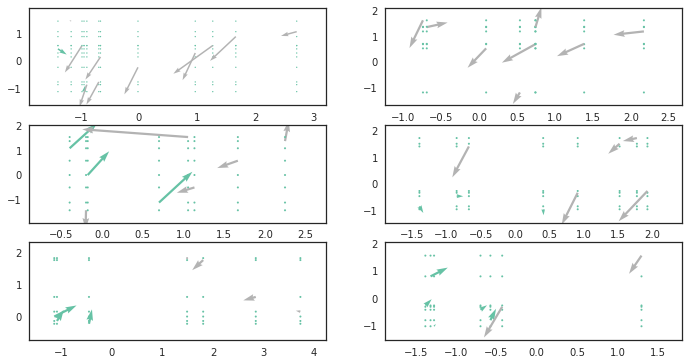

In [506]:
plot_action_transition(vectors, actions=6)

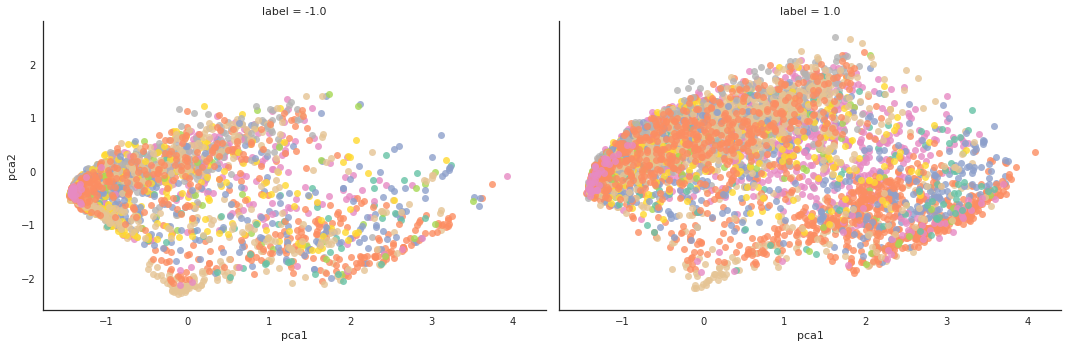

In [507]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

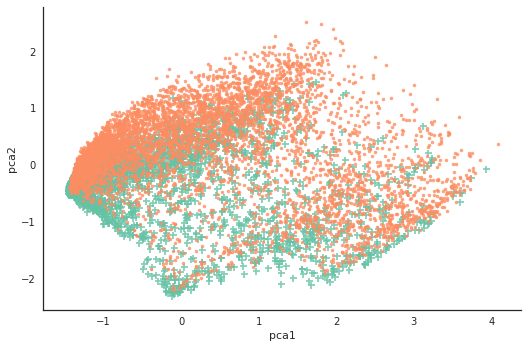

In [508]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='label', legend=False,
               fit_reg=False, size=5, aspect=1.5, palette='Set2', markers=['+', '.'])

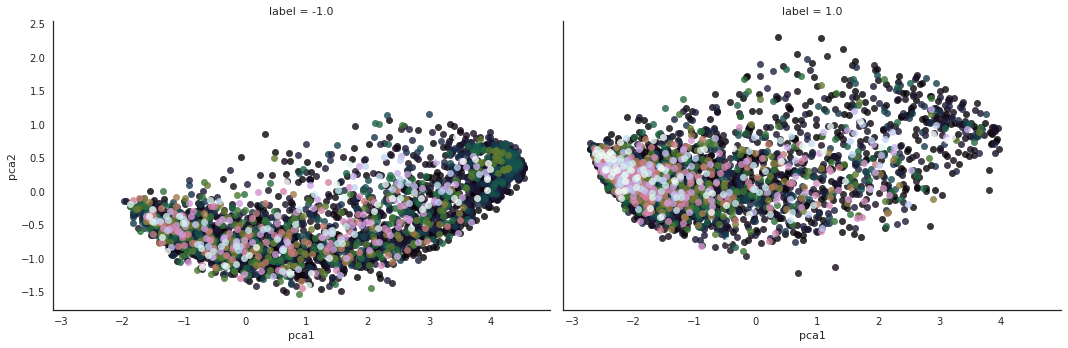

In [494]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

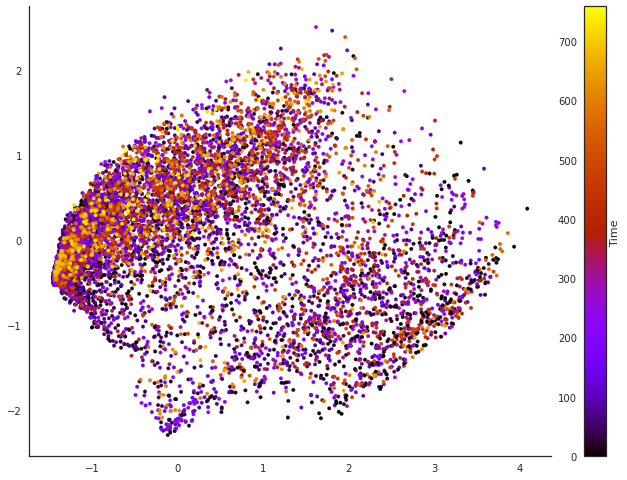

In [509]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.pca1.values, vectors.pca2.values, c=vectors.time_step.values, marker='.', cmap='gnuplot')
plt.colorbar(label="Time")
# plt.scatter(actions_pca[used_actions,0], actions_pca[used_actions,1], marker='*', s=200)
# for action_id, point in enumerate(actions_pca):
#     if action_id in used_actions:
#         plt.annotate(str(action_id), point)
seaborn.despine()

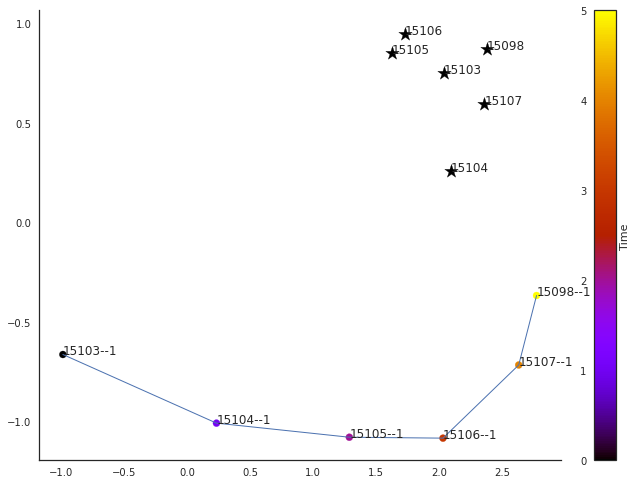

In [496]:
graphic_students(vectors, [1],  action_vectors=actions_pca, annotate=True) 

In [510]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(numpy.vstack(vectors.output.values))

vectors['tsne1'] = tsne_results[:,0]
vectors['tsne2'] = tsne_results[:,1] 

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9431 samples in 0.019s...
[t-SNE] Computed neighbors for 9431 samples in 1.919s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9431
[t-SNE] Computed conditional probabilities for sample 2000 / 9431
[t-SNE] Computed conditional probabilities for sample 3000 / 9431
[t-SNE] Computed conditional probabilities for sample 4000 / 9431
[t-SNE] Computed conditional probabilities for sample 5000 / 9431
[t-SNE] Computed conditional probabilities for sample 6000 / 9431
[t-SNE] Computed conditional probabilities for sample 7000 / 9431
[t-SNE] Computed conditional probabilities for sample 8000 / 9431
[t-SNE] Computed conditional probabilities for sample 9000 / 9431
[t-SNE] Computed conditional probabilities for sample 9431 / 9431
[t-SNE] Mean sigma: 0.085139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.776039
[t-SNE] Error after 300 iterations: 3.928791


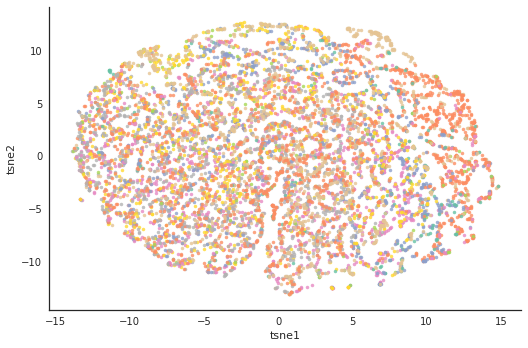

In [511]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, palette='Set2', markers='.')

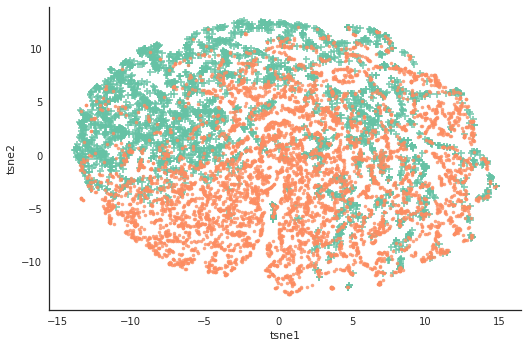

In [512]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='label', legend=False,
               fit_reg=False, size=5, aspect=1.5, palette='Set2', markers=['+', '.'])

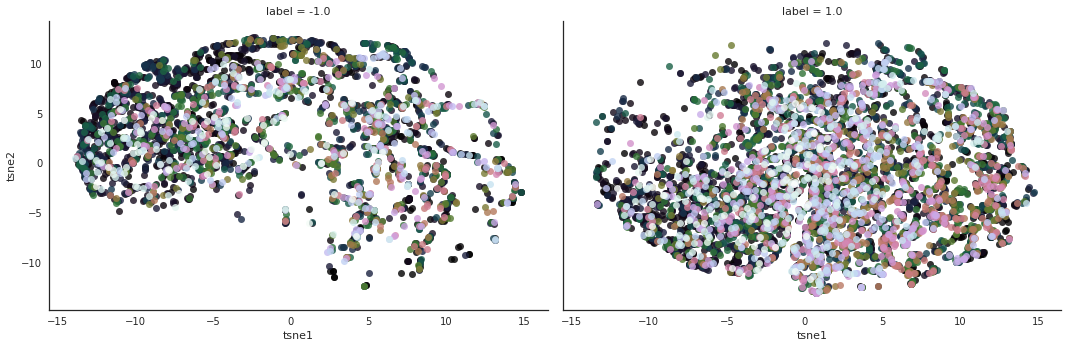

In [513]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

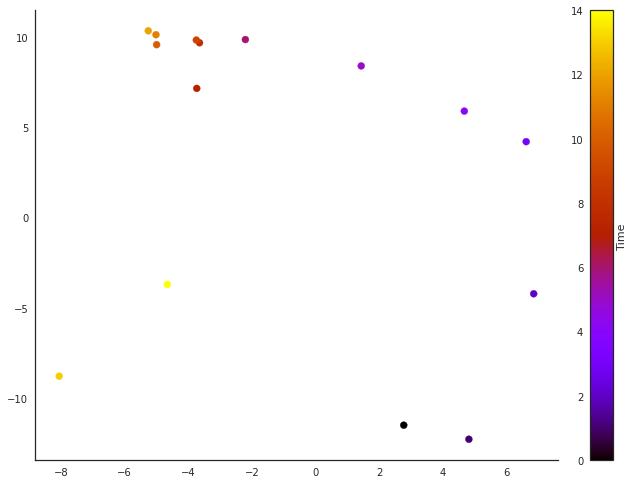

In [514]:
graphic_students(vectors, [10], xcol='tsne1', ycol='tsne2', annotate=False, lines=False) 

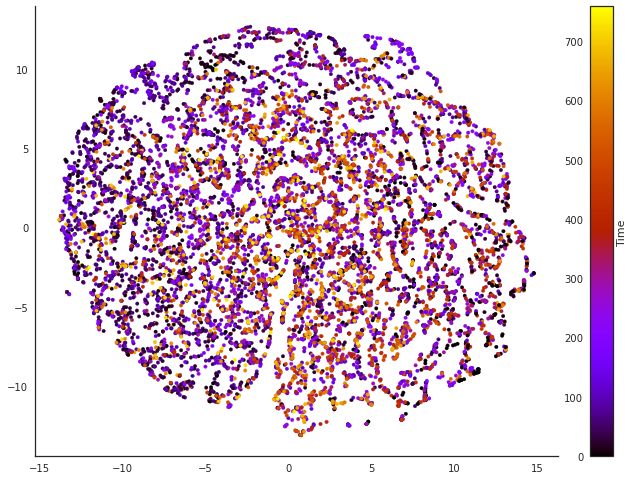

In [515]:
plt.scatter(vectors.tsne1.values, vectors.tsne2.values, c=vectors.time_step.values, marker='.', cmap='gnuplot')
plt.colorbar(label="Time")
seaborn.despine()

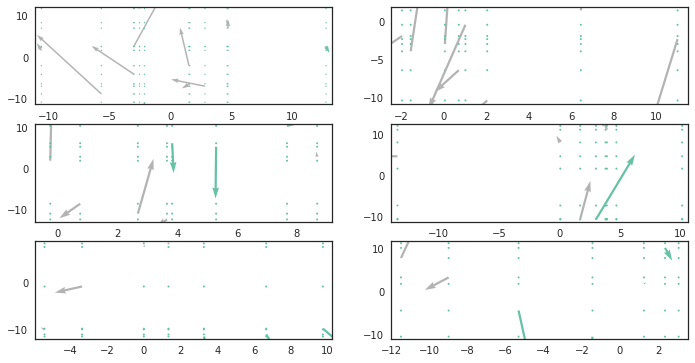

In [516]:
plot_action_transition(vectors, actions=6, xcol='tsne1', ycol='tsne2')